In [ ]:
#Para uma explicação detalhada sobre esse projeto, visite 
#meu portfolio em: https://henriquelucasdf.github.io/post/projeto2/

# 0.0 Configurações iniciais

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 0.1 Imports

In [2]:
!pip install fuzzywuzzy;

In [3]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import Image
from IPython.core.display import display, HTML


from sklearn.preprocessing import LabelEncoder

### 0.2 Funções

In [4]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [20, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set() 
    
jupyter_settings()

def separador_vendedor(x):
  if x != 'VENDA DIRETA':
    try:
      y = x.split(' ')
      int(y[0])
      return y[1]
    except:
      return y[0]
  else:
    return x



Populating the interactive namespace from numpy and matplotlib


# 1.0 Análise Inicial dos dados

### 1.1 Carregando os dados

In [5]:
df_raw1 = pd.read_excel('/content/drive/My Drive/data_science/repos/previsao_vendas_morana/dados/vendas_vendedor.xlsx')
df_raw2 = pd.read_excel('/content/drive/My Drive/data_science/repos/previsao_vendas_morana/dados/vendas_vendedor2.xlsx')
df_raw3 = pd.read_excel('/content/drive/My Drive/data_science/repos/previsao_vendas_morana/dados/vendas_vendedor3.xlsx')

### 1.2 Tamanho dos dados:

In [6]:
print('df1:', df_raw1.shape)
print('df2:', df_raw2.shape)
print('df3:', df_raw3.shape)

df1: (65534, 22)
df2: (65534, 22)
df3: (65365, 23)


### 1.3 Retirando colunas desnecessárias


In [7]:
df_raw1 = df_raw1.drop(columns = ['valorl', 'operador', 'cupom', 'caixa', 'dtinicio', 'dtfim', 'comissao', 'vlrcomissao', 'rede', 'filial', 'nomeloja'])
df_raw2 = df_raw2.drop(columns = ['valorl', 'operador', 'cupom', 'caixa', 'dtinicio', 'dtfim', 'comissao', 'vlrcomissao', 'rede', 'filial', 'nomeloja'])
df_raw3 = df_raw3.drop(columns = ['valorl', 'operador', 'cupom', 'caixa', 'dtinicio', 'dtfim', 'comissao', 'vlrcomissao', 'rede', 'filial', 'nomeloja', 'Unnamed: 22'])

### 1.4 Unindo os DataFrames

In [8]:
df1 = pd.concat([df_raw1, df_raw2, df_raw3], ignore_index=True)

### 1.5 Retirando dados duplicados

In [9]:
df1 = df1.drop_duplicates()

### 1.6 Tipos de dados

In [10]:
df1.dtypes

vendedor               object
data           datetime64[ns]
idcupom                object
tipo                   object
produto                 int64
nomeproduto            object
qtde                    int64
valorb                float64
descontos             float64
acrescimos            float64
vlrbascom             float64
dtype: object

### 1.7 Checando NAs

In [11]:
df1.isna().sum()
#apenas 2 NAs

vendedor        0
data            0
idcupom        58
tipo            0
produto         0
nomeproduto     2
qtde            0
valorb          0
descontos       0
acrescimos      0
vlrbascom       0
dtype: int64

### 1.8 Preenchendo os NAs

In [12]:
df1[df1['nomeproduto'].isna()]

,vendedor,data,idcupom,tipo,produto,nomeproduto,qtde,valorb,descontos,acrescimos,vlrbascom
145476,VALESKA-000113400021,2019-01-09,000113420190109003253,DEVOLUÇÃO,1644731501,NaN,-1,-99.9,0.0,0.0,-99.9
146093,JANE-000113400009,2019-01-18,0001134180120190000400001,V,1644731501,NaN,1,99.9,0.0,0.0,99.9


In [13]:
df1['nomeproduto'][df1['nomeproduto'].isna()] = 'COLAR DOURADO'
# Como temos o código, basta encontrar o nome do produto no site da Franqueadora

In [14]:
df1[df1['idcupom'].isna()].head()

,vendedor,data,idcupom,tipo,produto,nomeproduto,qtde,valorb,descontos,acrescimos,vlrbascom
168529,05 LIZA-000113400005,2019-10-30,NaN,ESTORNO,5740134184,PULS 00413 AROS LI/TR C/BASE LI PON,-1,-59.9,0.0,0.0,-59.9
168572,VALESKA-000113400021,2019-10-30,NaN,ESTORNO,2404080012,BRINCO 00420 CIRC/GOT/OVAIS ZIRCO,-1,-359.9,0.0,0.0,-359.9
168716,VALESKA-000113400021,2019-11-01,NaN,ESTORNO,2945941911,BR 00192 BOL LI/CIR TRA VAZ ENTRELA,-1,-39.9,0.0,0.0,-39.9
168977,05 LIZA-000113400005,2019-11-04,NaN,ESTORNO,2657071471,BR 00050 CI LI C/BASE ACRI/BAS LISA,-1,-69.9,0.0,0.0,-69.9
168978,05 LIZA-000113400005,2019-11-04,NaN,ESTORNO,1154371911,COL 00196 GRAV/CIR TRAB VAZ ENTRELA,-1,-89.9,0.0,0.0,-89.9


In [15]:
df1['idcupom'][df1['idcupom'].isna()] = '-1'

### 1.9 Datas inicial e Final

In [16]:
print("Data inicial: {}".format(df1.loc[0,'data']))
print("Data final: {}".format(df1.loc[df1.index[-1],'data']))

Data inicial: 2014-01-02 00:00:00
Data final: 2020-10-31 00:00:00


#2.0 Criação de Hipóteses de Negócio

  - H1. Peças com valor entre RS 29,90 e RS 49,90 são as mais vendidas.
  - H2. Peças douradas são as mais vendidas.
  - H3. Peças de RS 39,90 são as mais vendidos.

  - H4. Colares são os itens com maior quantidade vendida.
  - H5. Colares dourados de RS 39,90 são os itens com maior quantidade vendida.
  - H6. 80% do faturamento mensal é proveniente de itens dourados.
  - H7. 80% do faturamento mensal é proveniente de colares dourados.
  - H8. 80% das devoluções são de pulseiras prata.
  - H9. A maioria das devoluções ocorrem em janeiro.
  - H10. Dezembro é o mês com maior faturamento.
  - H11. Sábado é o dia da semana com maior faturamento.
  - H12. Conjuntos correspondem a 20% do faturamento em Dezembro.
  - H13. Conjuntos possuem a maior média de preço.
  - H14. Jane é a vendedora que mais vende.
  - H15. A média de itens por cliente é de 2 peças.
  - H16. Ao menos 20% das vendas estão acima do Ticket Médio em dezembro.
  - H17. Ao menos 5% do faturamento é proveniente de vendas com valor acima de R$500,00
  - H18. O faturamento médio caiu após a pandemia. 
  - H19. O número de clientes caiu após a pandemia.

#3.0 Feature Enginnering

In [18]:
df2 = df1.copy()

### 3.1 Datas

In [19]:
#Separando a data em dia, mes, ano
df2['ano'] = df2['data'].dt.year
df2['mes'] = df2['data'].dt.month
df2['dia'] = df2['data'].dt.day

#dia da semana
df2['dia_semana']= df2['data'].dt.dayofweek

#A semana do ano será derivada posteriormente para ser utilizada no modelo, já que o método datetime apresenta inconsistências. 

### 3.2 Vendedor 

In [20]:
#vendedor - separando os nomes:
df2['vendedor'] = df2['vendedor'].apply(lambda x: x.split('-')[0])

#Foi criada uma função "separador_vendedor" para lidar com esta feature (Ver item 0.2)
#retirando os numeros existentes
df2['vendedor']=df2['vendedor'].map(separador_vendedor)

### 3.3 Nome do produto

In [21]:
#Cada código corresponde a um nome. Exemplo: começa com 1 - colar, termina com 1 - dourado. 
dic_nome = {
    '1': 'colar',
    '2': 'brinco',
    '3': 'anel',
    '4': 'conjunto',
    '5': 'pulseira',
    '6': 'diversos',
    '7': 'diversos',
    '8': 'diversos',
    '9': 'diversos'}

dic_cor = {
    '1': 'dourado',
    '2': 'prata',
    '3': 'colorido',
    '4': 'grafite',
    '5': 'colorido',
    '6': 'colorido',
    '7': 'colorido',
    '8': 'colorido',
    '9': 'colorido',
    '0': 'colorido'}
  


In [22]:
df2['nome'] = df2['produto'].apply(lambda x: str(x)[0])
df2['nome'] = df2['nome'].map(dic_nome)

In [23]:
df2['cor'] = df2['produto'].apply(lambda x: str(x)[-1])
df2['cor'] = df2['cor'].map(dic_cor)

In [24]:
df2['nomeproduto'] = df2[['nome', 'cor']].apply(lambda x: x['nome']+'_'+ x['cor'], axis=1)

In [25]:
#Coluna produto é redundante
df2 = df2.drop(columns=['produto'])

### 3.4 Operação realizada

In [26]:
#cada id cupom corresponde a um cliente (uma operação). 
#Fazer o Label Encoder da features idcupom para tornar a coluna mais legível
le = LabelEncoder()
df2['idcupom'] = le.fit_transform(df2['idcupom'])

In [27]:
#Renomeando as colunas
df2.columns = ['vendedor', 'data', 'cliente','tipo', 'nomeproduto', 'qtde', 'valor_base', 'descontos', 
               'acrescimos', 'valor_final', 'ano', 'mes', 'dia', 'dia_semana','item','cor']

# 4.0 Análise Exploratória de Dados

In [28]:
df3 = df2.copy()

In [ ]:
df3.sample(1)

,vendedor,data,cliente,tipo,nomeproduto,qtde,valor_base,descontos,acrescimos,valor_final,ano,mes,dia,dia_semana,item,cor
85690,DAYANE,2016-12-23,64652,DEVOLUÇÃO,colar_dourado,-1,-89.0,0.0,0.0,-89.0,2016,12,23,4,colar,dourado


### H1. Peças com valor entre 29,90 e 49,90 são as mais vendidas. 

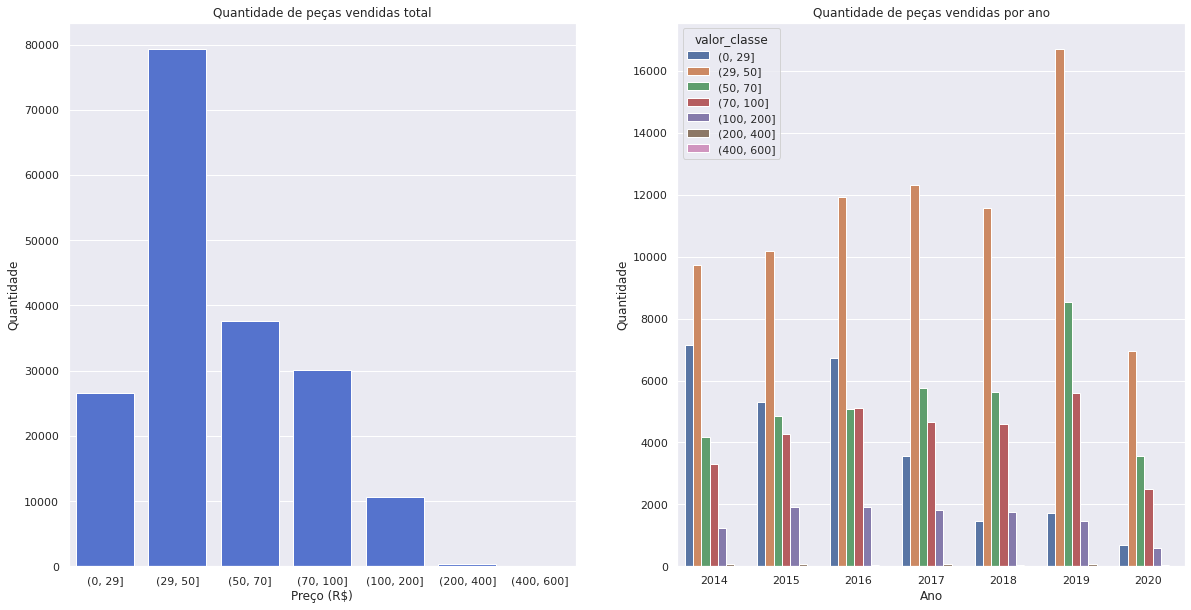

In [ ]:
#@title **Verdadeira.** Peças entre 29 e 50 reais sempre são as mais vendidas. Houve uma mudança na segunda classe que mais vende a partir do ano 2017. (clique duas vezes para visualizar o código)
#Incluindo apenas as vendas
aux1 = df3[df3['tipo']=='V']
aux1 = aux1[['valor_base', 'qtde','ano']]

#separando em classes: 
classes = [0,29,50,70,100,200,400,600]
aux1['valor_classe'] = pd.cut(aux1['valor_base'], bins = classes)
aux1_1 = aux1[['valor_classe', 'qtde']].groupby(
              'valor_classe').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='valor_classe', y='qtde', data=aux1_1, color='royalblue')
plt.title("Quantidade de peças vendidas total")
plt.xlabel("Preço (R$)")
plt.ylabel("Quantidade");

#Evolução ano a ano
aux1_2 = aux1[['valor_classe', 'qtde','ano']].groupby(
              ['valor_classe','ano']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='ano', y='qtde', hue= 'valor_classe', data=aux1_2)
plt.title("Quantidade de peças vendidas por ano")
plt.xlabel("Ano")
plt.ylabel("Quantidade");


### H2. Peças douradas são as mais vendidas.

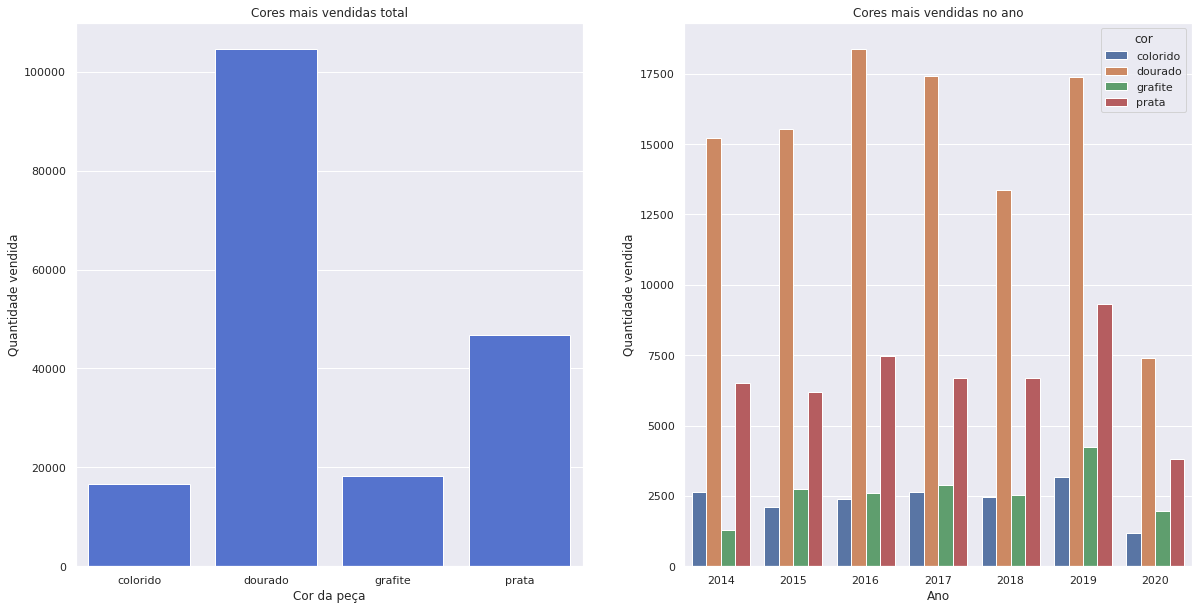

In [ ]:
#@title **Verdadeiro.** Dourado sempre é a cor de peça mais vendida. Em segundo vem as peças pratas.
aux2 = df3[['nomeproduto', 'qtde','ano','cor']].copy()

#Apenas vendas:
aux2 = aux2[aux2['qtde']>0]

#Agrupando todos os anos:
aux2_1 = aux2[['cor', 'qtde']].groupby('cor').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x='cor', y='qtde', data=aux2_1, color='royalblue')
plt.title("Cores mais vendidas total") 
plt.ylabel("Quantidade vendida")
plt.xlabel("Cor da peça")

#Agrupando ano a ano
aux2_2 =  aux2[['cor', 'qtde','ano']].groupby(
              ['cor','ano']).sum().reset_index()
plt.subplot(1,2,2)
sns.barplot(x='ano', y='qtde', hue='cor', data=aux2_2)
plt.title("Cores mais vendidas no ano")                                       
plt.ylabel("Quantidade vendida")
plt.xlabel("Ano");                               

### H3. Peças de R$39,90 são as mais vendidas.

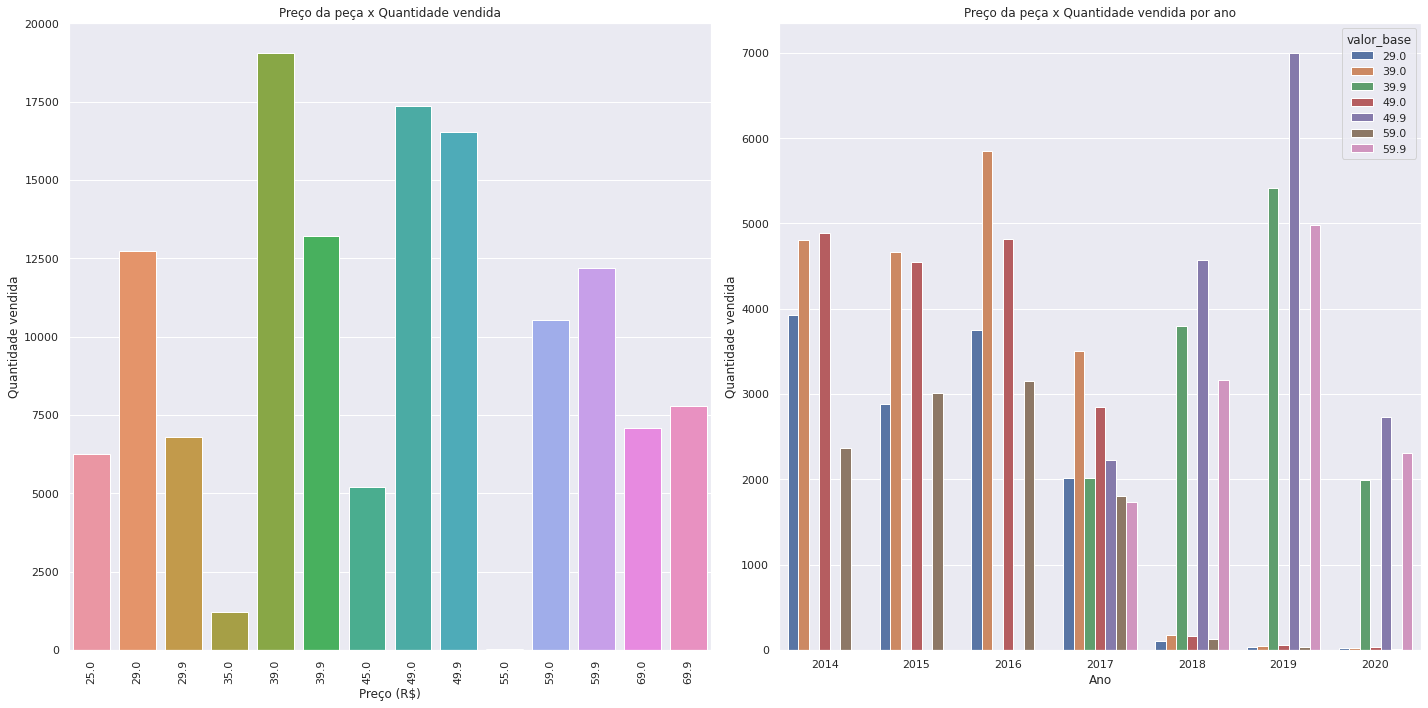

In [ ]:
#@title **Falsa.** Até 2017, as peças mais vendidas eram as de R$39,00. A partir de 2018, passou a ser as de R$49,90.
#Apenas vendas e valor_base entre 25 e 100 reais
aux3 = df3[(df3['tipo']=='V') & (df3['valor_base']>=25) & (df3['valor_base']<75)].copy()
aux3 = aux3[['qtde','valor_base', 'ano']]

#
#Separar em classes
classes3 = [25,36,50 ]
aux1['valor_classe'] = pd.cut(aux1['valor_base'], bins = classes)
#Todos os anos

aux3_1 = aux3[['valor_base','qtde']].groupby('valor_base').sum().reset_index()
plt.subplot(1,2,1)
sns.barplot(x= 'valor_base', y='qtde', data=aux3_1)
plt.xticks(rotation=90);
plt.xlabel("Preço (R$)")
plt.ylabel("Quantidade vendida")
plt.title("Preço da peça x Quantidade vendida")

#Ano a ano, pegando os principais valores:

aux3_2 = aux3[aux3['valor_base'].isin([29, 39, 39.9, 49, 49.9, 59, 59.9])]
aux3_2 = aux3_2[['valor_base','qtde','ano']].groupby(['valor_base','ano']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x= 'ano', y='qtde',hue = 'valor_base', data=aux3_2)
plt.xlabel("Ano")
plt.ylabel("Quantidade vendida")
plt.title("Preço da peça x Quantidade vendida por ano")

plt.tight_layout()

### H4. Colares são os itens com a maior quantidade vendida.

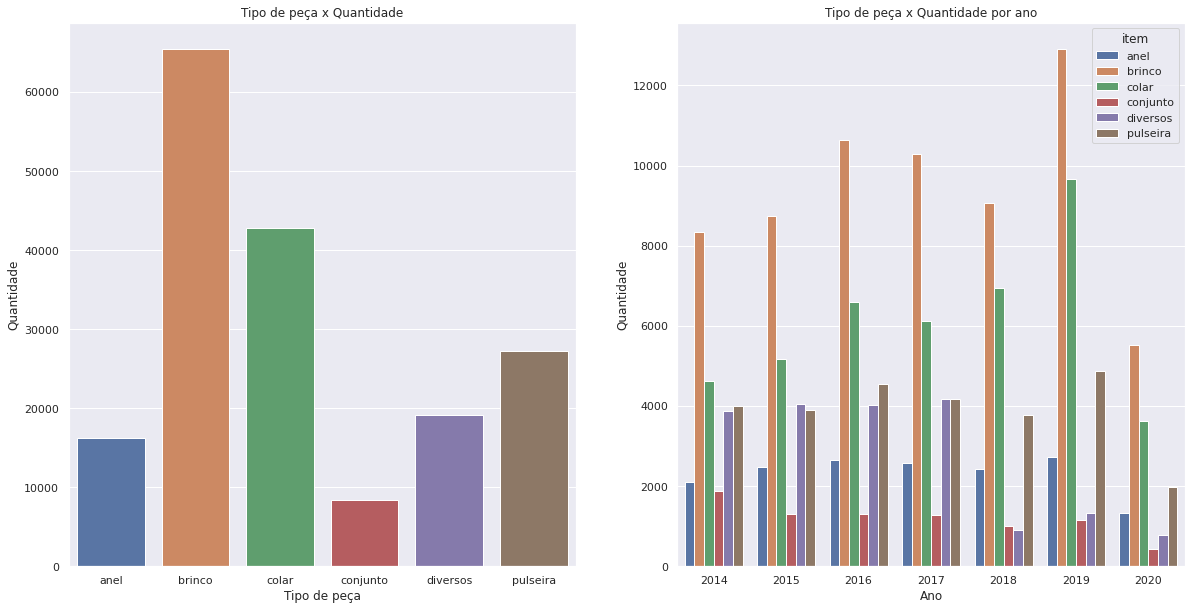

In [ ]:
#@title **Falso.** Brincos sempre são os itens mais vendidos. 

aux4 = df3[['nomeproduto', 'qtde', 'ano','item']].copy()


aux4_1 = aux4[['item', 'qtde']].groupby('item').sum().reset_index()

plt.subplot(1,2,1)
sns.barplot(x='item', y='qtde', data = aux4_1)
plt.xlabel("Tipo de peça")
plt.ylabel ("Quantidade")
plt.title("Tipo de peça x Quantidade")

aux4_2 = aux4[['item', 'qtde','ano']].groupby(
              ['item','ano']).sum().reset_index()

plt.subplot(1,2,2)
sns.barplot(x='ano', y='qtde',hue='item', data = aux4_2)
plt.xlabel("Ano")
plt.ylabel ("Quantidade")
plt.title("Tipo de peça x Quantidade por ano");

### H5. Colares dourados de R$39,90 são os itens com maior quantidade vendida

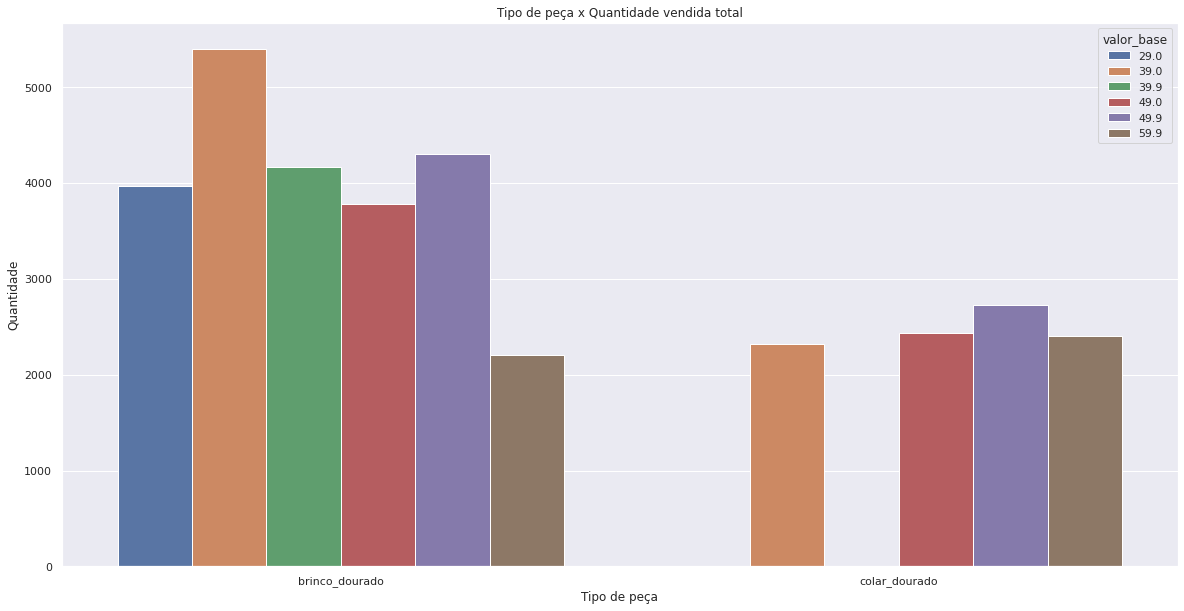

In [ ]:
#@title **Falsa.** Brincos dourados de R$39,00 são os itens mais vendidos.
aux5 = df3[df3['tipo']=='V']
aux5 = aux5[['nomeproduto', 'qtde', 'valor_base','ano']].copy()

#Agrupando
aux5_1 = aux5[['nomeproduto', 'qtde', 'valor_base']].groupby(
              ['nomeproduto','valor_base']).sum().reset_index()

aux5_1 = aux5_1.sort_values('qtde', ascending=False).head(10)


#Plotando
sns.barplot(x='nomeproduto', y='qtde', hue='valor_base', data = aux5_1)
plt.xlabel("Tipo de peça")
plt.ylabel ("Quantidade")
plt.title("Tipo de peça x Quantidade vendida total");


### H6. 80% do faturamento mensal é proveniente de itens dourados.

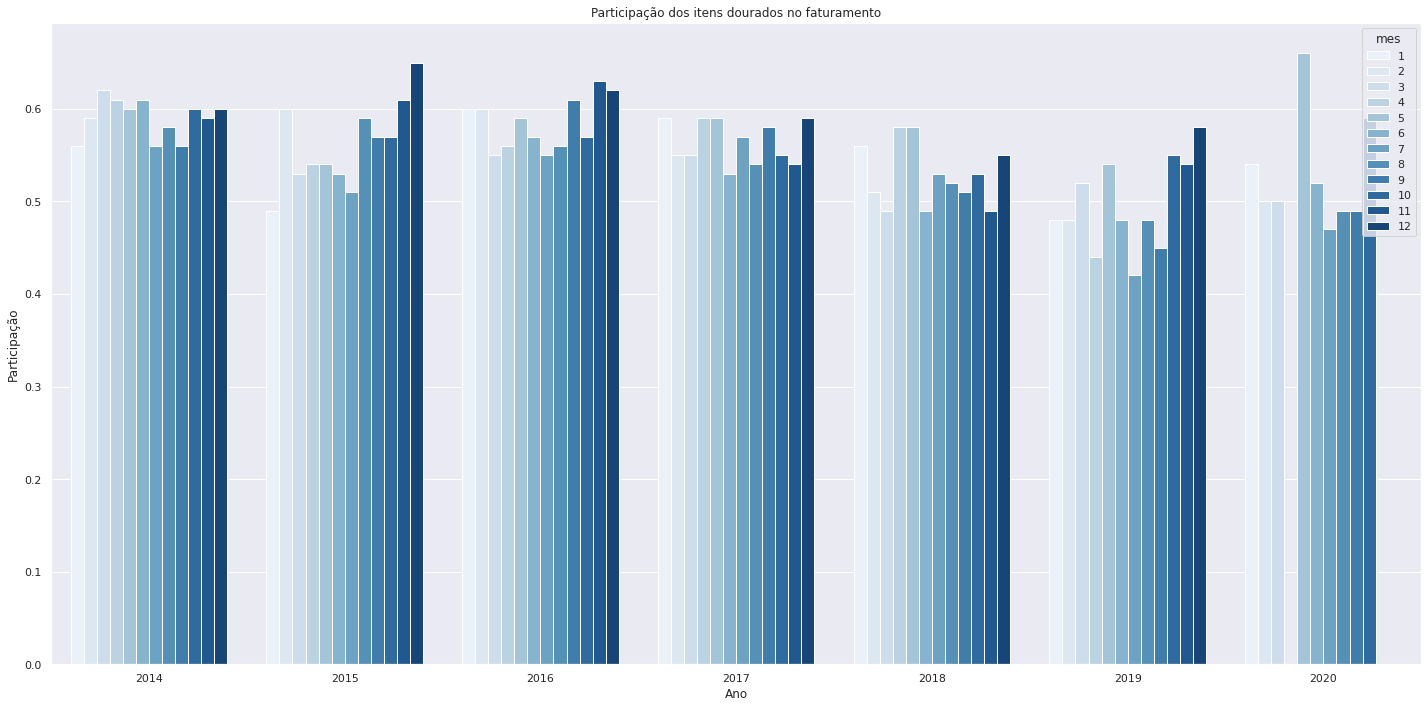

In [58]:
#@title **Falso.** A participação de itens dourados nunca passou de 70%. 

aux6 = df3[df3['tipo']=='V']
aux6 = aux6[['cor', 'valor_final','ano','mes']]

aux6_1 = aux6.groupby(['ano','mes','cor']).sum().reset_index()

#Dividindo em duas classes: 
aux6_1['cor'] = aux6_1['cor'].apply(lambda x: 'dourado' if x == 'dourado'
                                    else 'outra_cor')
aux6_1 = aux6_1.groupby(['ano','mes','cor']).sum().reset_index()

#Faturamento mensal:
aux = aux6_1[['ano','mes','valor_final']].groupby(
                       ['ano','mes']).sum().reset_index()
#retirando os que não são dourados:
aux6_1 = aux6_1[aux6_1['cor']=='dourado']
#Juntando os dataframes: 

aux6_1 = pd.merge(aux6_1,aux, on = ['ano','mes'])

#Coluna percentual:
aux6_1['participação'] = np.round(aux6_1['valor_final_x']
                                  /aux6_1['valor_final_y'], decimals=2)

#Plotando: 
plt.subplot(2,1,1)
sns.barplot(x='ano', y='participação', hue='mes', 
            data=aux6_1, palette='Blues')
plt.title("Participação dos itens dourados no faturamento")
plt.ylabel("Participação")
plt.xlabel("Ano");

### H7. 80% do faturamento mensal é proveniente de colares dourados.

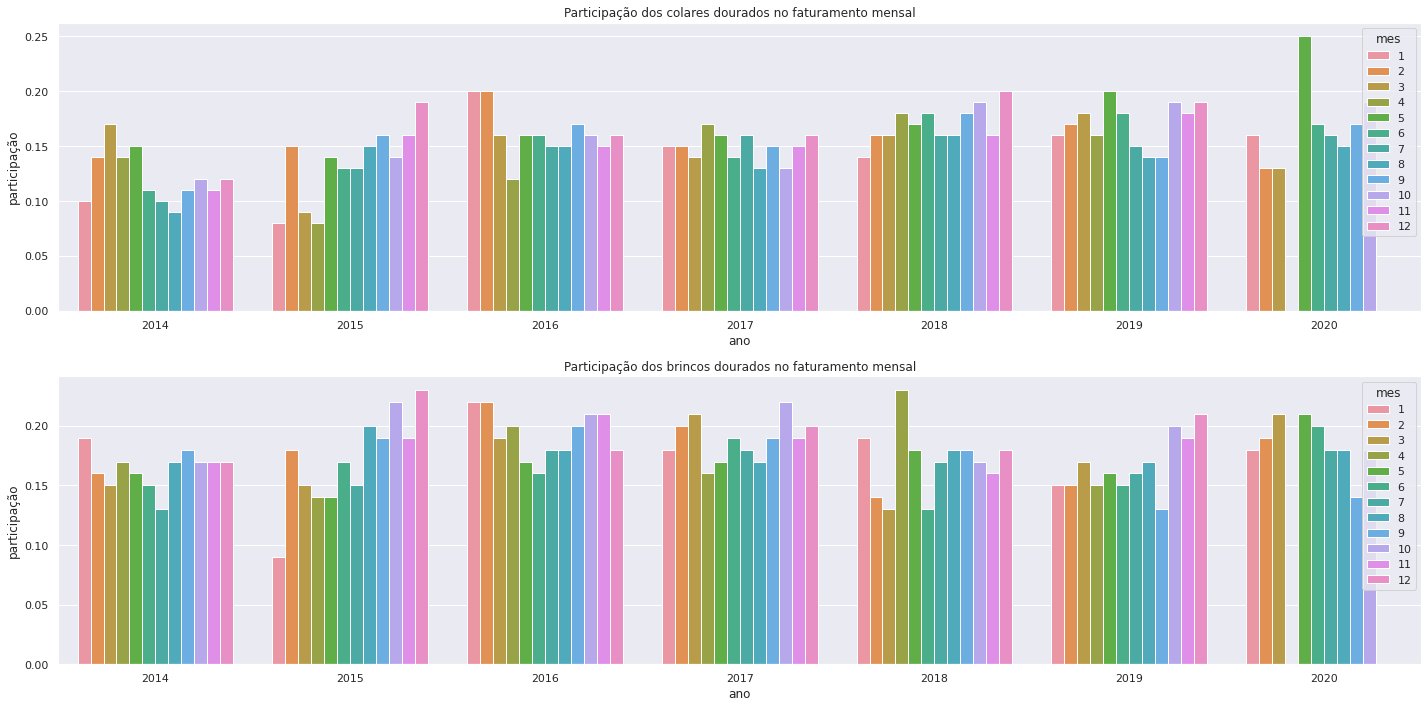

In [ ]:
#@title **Falsa.** Os colares dourados correspondem a cerca de 15% do faturamento mensal, assim como os brincos dourados.
aux7 = df3[df3['tipo']=='V']
aux7 = aux7[['nomeproduto','ano','mes','valor_final']].copy()
aux7 = aux7.groupby(['nomeproduto','ano','mes']).sum().reset_index()

#Separando brincos e colares dourados
aux7_1 = aux7.copy()
aux7_1['nomeproduto'] = aux7_1['nomeproduto'].apply(lambda x: 
                                     'colar_dourado' if
                                     x == 'colar_dourado' else 
                                     'brinco_dourado' if 
                                     x == 'brinco_dourado'
                                     else 'outros')

#obtendo faturamento mensal
df7 = aux7_1[['ano','mes','valor_final']].groupby(['ano','mes']).sum().reset_index()

#mantendo apenas brincos e colares dourados:
aux7_colar = aux7_1[(aux7_1['nomeproduto'] == 'colar_dourado')]
aux7_brinco = aux7_1[(aux7_1['nomeproduto'] == 'brinco_dourado')]

#Fazendo o merge:
aux7_colar = pd.merge(aux7_colar,df7, on=['ano','mes'])
aux7_brinco = pd.merge(aux7_brinco,df7, on=['ano','mes'])

#Fazendo o percentual:
aux7_colar['participação'] = np.round(aux7_colar['valor_final_x']/
                      aux7_colar['valor_final_y'], decimals=2)

aux7_brinco['participação'] = np.round(aux7_brinco['valor_final_x']/
                      aux7_brinco['valor_final_y'], decimals=2)

# Plotando os gráficos:
plt.subplot(2,1,1)
sns.barplot(x='ano', y='participação',hue='mes',data=aux7_colar)
plt.title("Participação dos colares dourados no faturamento mensal")
plt.tight_layout()

plt.subplot(2,1,2)
sns.barplot(x='ano', y='participação',hue='mes',data=aux7_brinco)
plt.title("Participação dos brincos dourados no faturamento mensal")
plt.tight_layout()


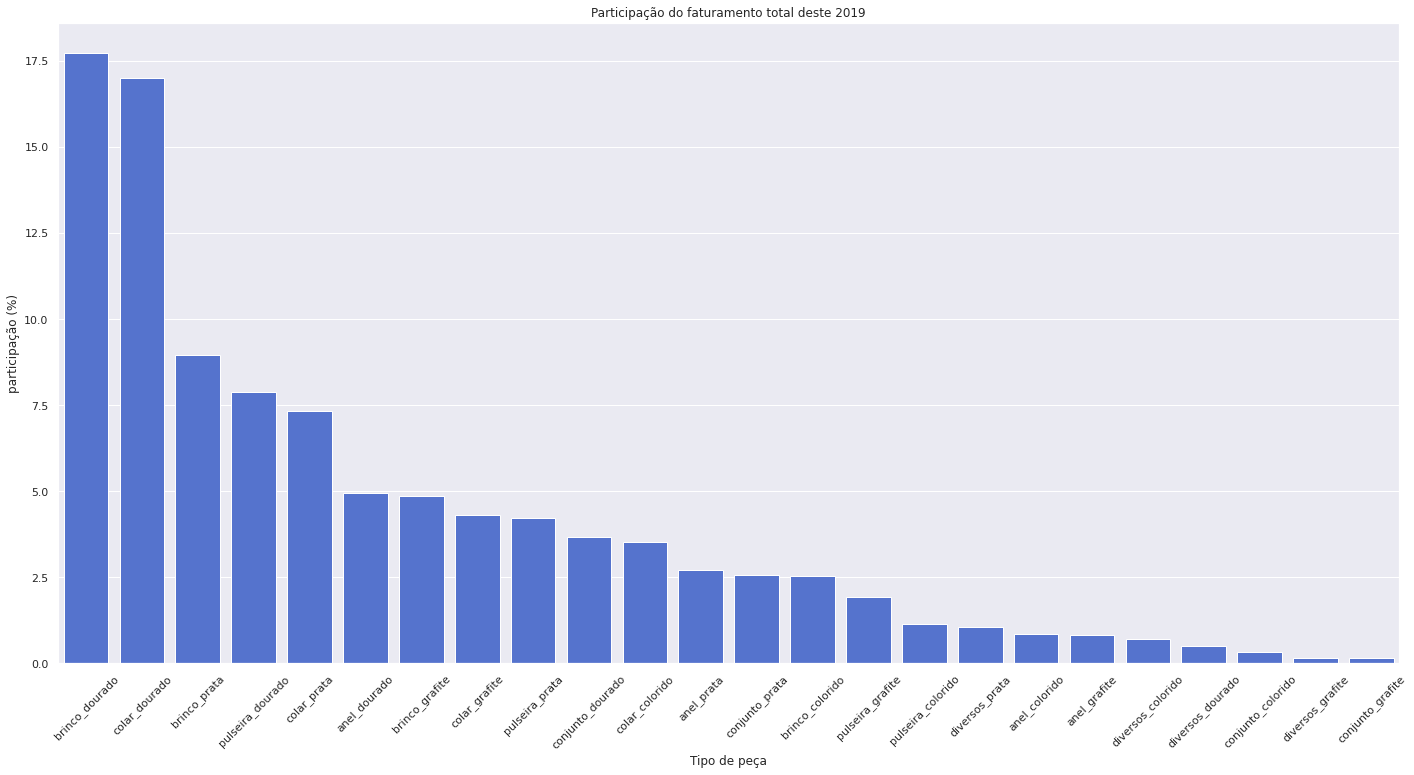

In [ ]:
#@title Participação de cada peça no faturamento total desde 2019
bns1 = aux7[aux7['ano']>=2019].copy()
fat_total = sum(bns1['valor_final'])

#Agrupando por tipo de peça
bns1 = bns1[['nomeproduto','valor_final']].groupby(
            ['nomeproduto',]).sum().reset_index()
#Participação
bns1['participação (%)'] = 100*np.round(bns1['valor_final']/fat_total, decimals=4)
bns1 = bns1.sort_values('participação (%)', ascending=False)

sns.barplot(x='nomeproduto', y='participação (%)', data=bns1, color='royalblue')
plt.title("Participação do faturamento total deste 2019")
plt.xlabel('Tipo de peça')
plt.tight_layout()
plt.xticks(rotation=45);

### H8. 80% das devoluções são de pulseiras prata.

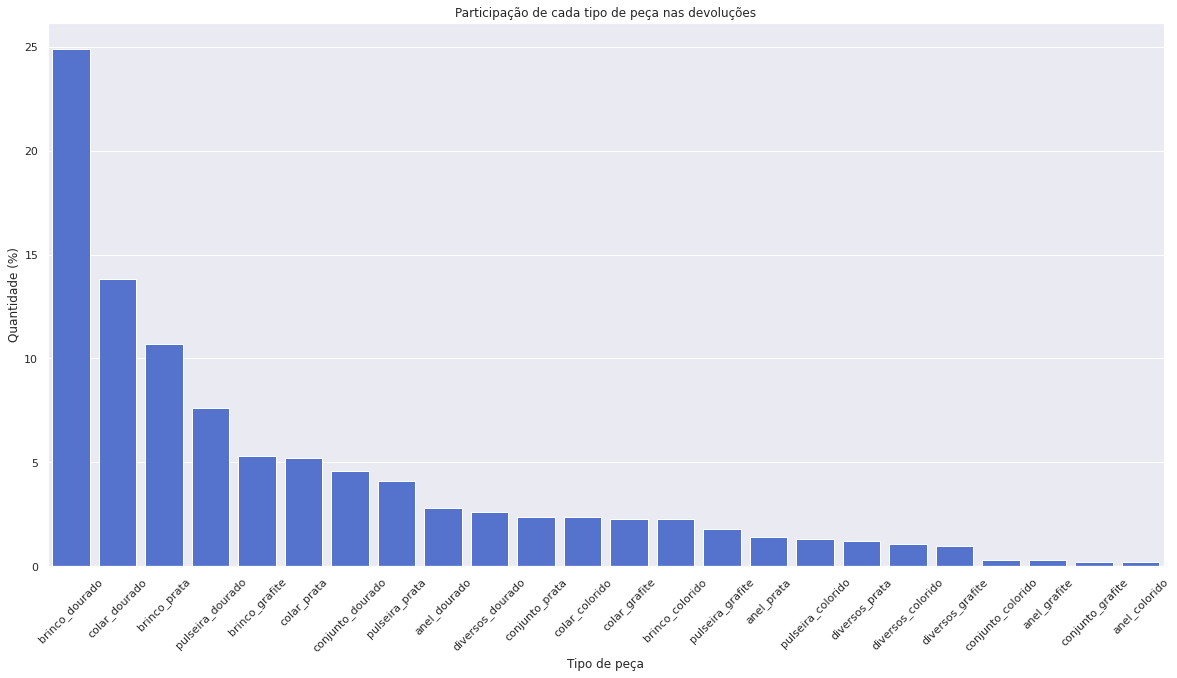

In [ ]:
#@title **Falsa.** Brincos dourados são a maioria das devoluções. Correspondem a 25%, seguidos dos colares dourados.
aux8 = df3[df3['tipo']=='DEVOLUÇÃO'].copy()
aux8 = aux8[['nomeproduto','qtde']].groupby(
            'nomeproduto').sum().reset_index()

aux8['qtde'] = aux8['qtde']*-1
aux8['qtde'] = np.round(aux8['qtde']/sum(aux8['qtde']),decimals=3)*100
aux8 = aux8.sort_values('qtde', ascending=False)

sns.barplot(x='nomeproduto', y='qtde',data=aux8, color='royalblue')
plt.title("Participação de cada tipo de peça nas devoluções")
plt.ylabel("Quantidade (%)")
plt.xlabel("Tipo de peça")
plt.xticks(rotation=45);

### H9. A maioria das devoluções ocorrem em janeiro.

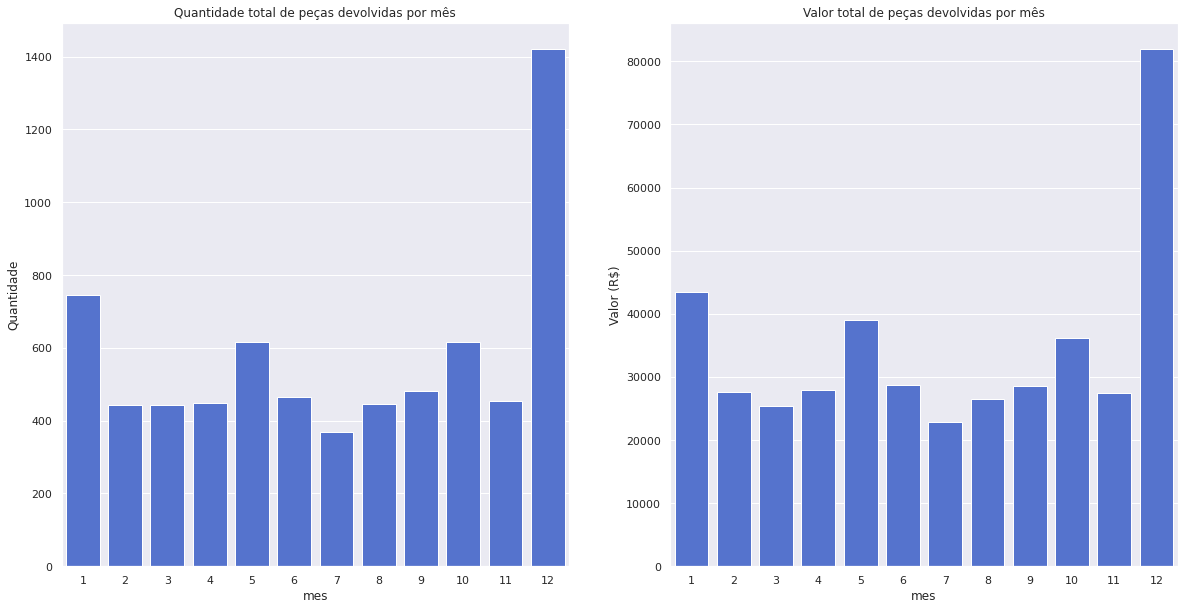

In [ ]:
#@title **Falsa.** A maior quantidade de devolução ocorre em Dezembro.
aux9 = df3[df3['tipo']=="DEVOLUÇÃO"]
aux9 = aux9[['mes', 'qtde','valor_final']].groupby('mes').sum().reset_index()
aux9['qtde'] = aux9['qtde']*-1
aux9['valor_final'] = aux9['valor_final']*-1

plt.subplot(1,2,1)
sns.barplot(x='mes', y= 'qtde', data=aux9, color='royalblue')
plt.title("Quantidade total de peças devolvidas por mês")
plt.ylabel("Quantidade")

plt.subplot(1,2,2)
sns.barplot(x='mes', y= 'valor_final', data=aux9, color='royalblue')
plt.title("Valor total de peças devolvidas por mês")
plt.ylabel("Valor (R$)");

### H10. Dezembro é o mês com maior faturamento.

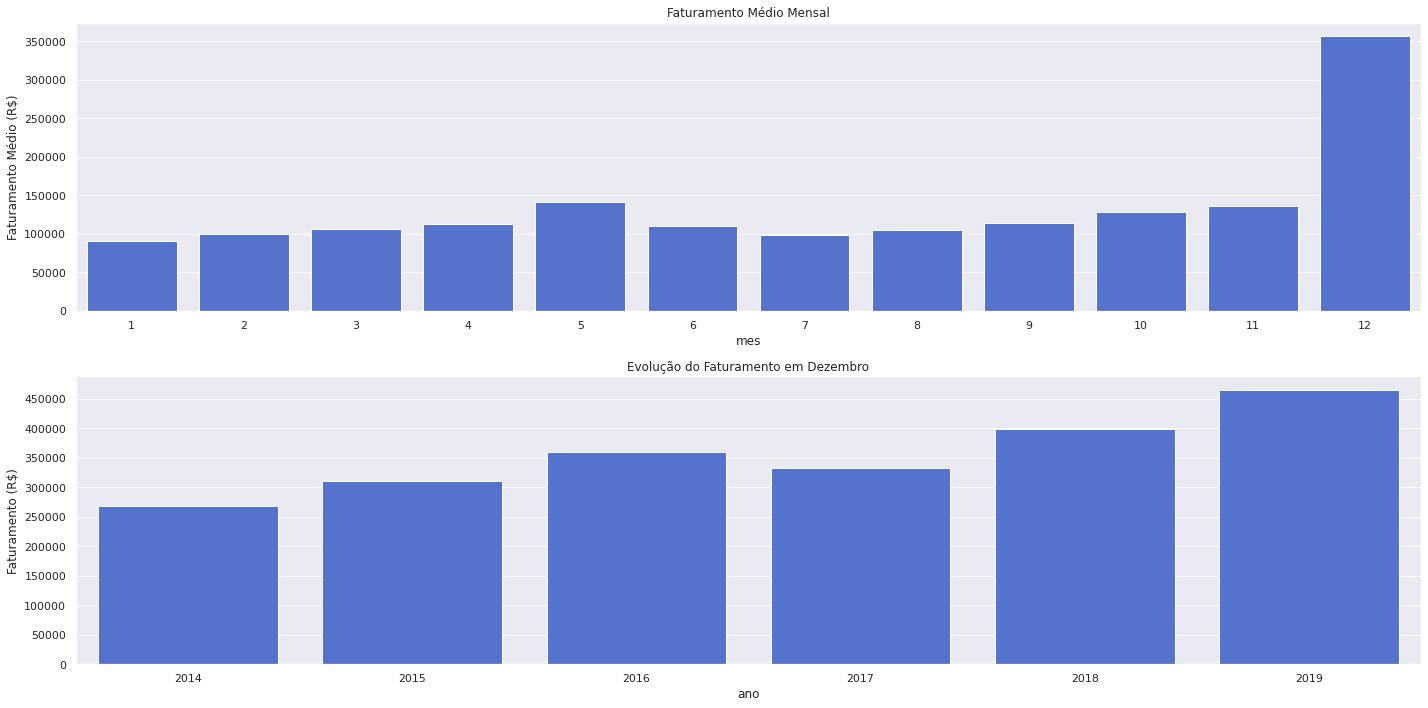

In [ ]:
#@title **Verdadeira.** Dezembro é o mês de maior faturamento, seguido por Maio.
aux10 = df3[df3['tipo']=='V']
aux10 = aux10[['ano','mes', 'valor_final']].groupby(
              ['ano','mes']).sum().reset_index()

aux10_1 = aux10[['mes','valor_final']].groupby('mes').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x = 'mes', y='valor_final', data=aux10_1, color='royalblue')
plt.title("Faturamento Médio Mensal")
plt.ylabel("Faturamento Médio (R$)")

aux10_2 = aux10[aux10['mes']==12]
plt.subplot(2,1,2)
sns.barplot(x = 'ano', y='valor_final', data=aux10_2, color='royalblue')
plt.title("Evolução do Faturamento em Dezembro")
plt.ylabel("Faturamento (R$)")
plt.yticks(np.arange(0,500000,50000))
plt.tight_layout()


### H11. Sábado é o dia da semana com maior faturamento.

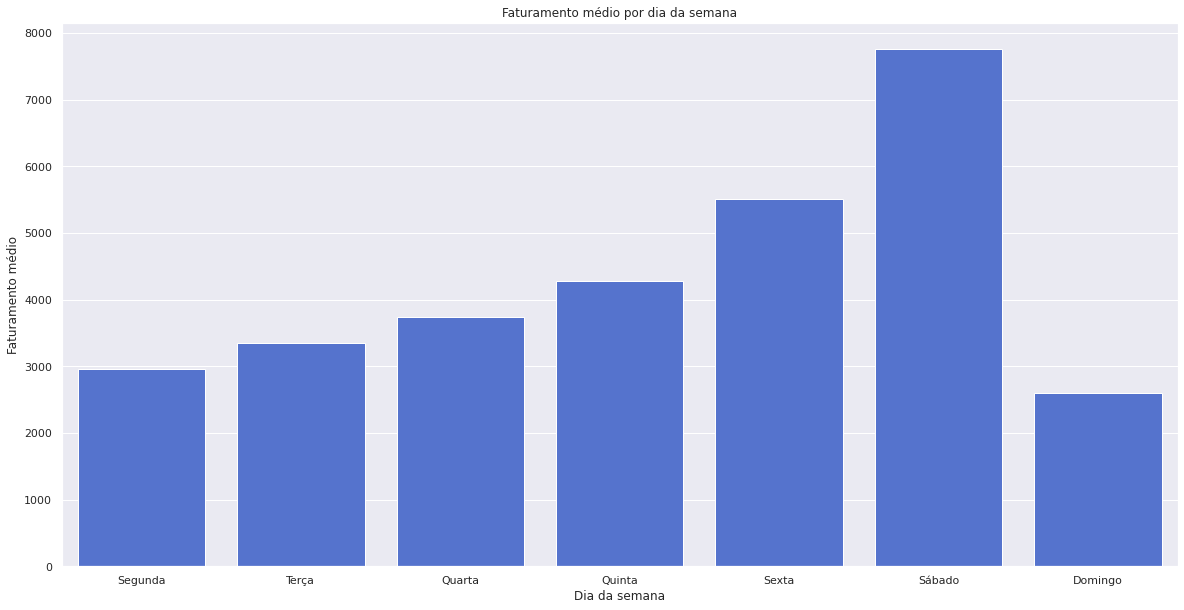

In [ ]:
#@title Verdadeira. Sábado é o que possui maior faturamento médio, seguido da sexta-feira. 

aux11 = df3[['data', 'dia_semana', 'valor_final']].groupby(['data',
            'dia_semana']).sum().reset_index()

aux11 = aux11[['dia_semana', 'valor_final']].groupby('dia_semana'
              ).mean().reset_index()

dic_semana = {
              0: "Segunda",
              1:'Terça',
              2:'Quarta',
              3:'Quinta',
              4:'Sexta',
              5:'Sábado',
              6:'Domingo'}

aux11['dia_semana'] = aux11['dia_semana'].map(dic_semana)

sns.barplot(x='dia_semana', y='valor_final', data=aux11, color='royalblue')
plt.title("Faturamento médio por dia da semana");
plt.ylabel("Faturamento médio")
plt.xlabel("Dia da semana");


### H12. Conjuntos correspondem a 20% do faturamento em Dezembro.

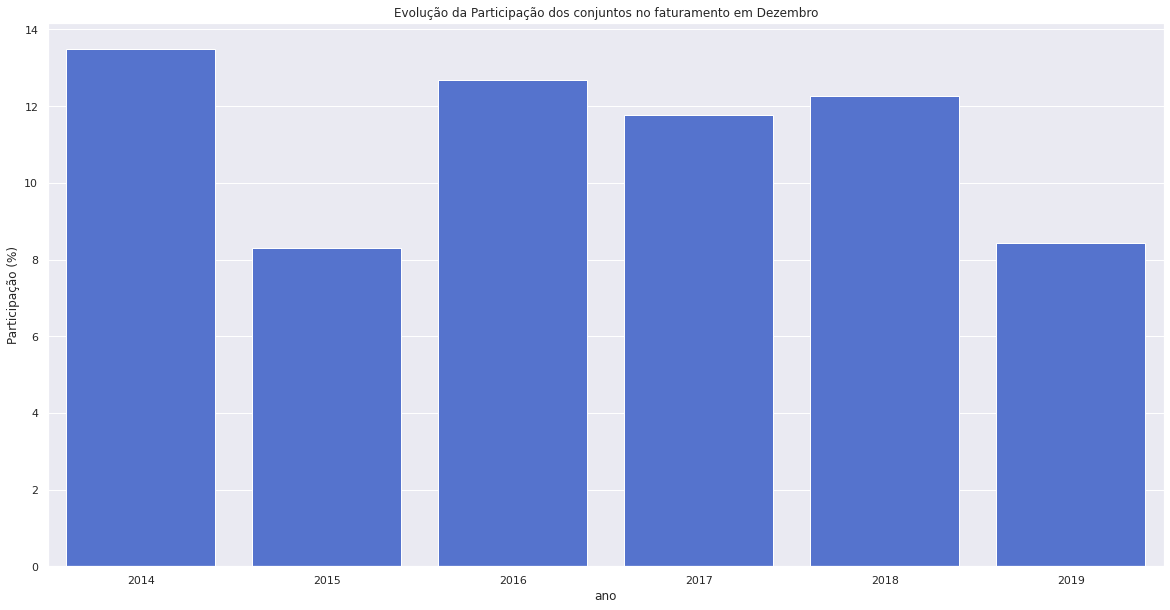

In [ ]:
#@title **Falsa.** Os conjuntos nunca participaram com 20% do faturamento em dezembro. O máximo (14%) ocorreu em 2014, e há uma tendência de queda.
aux12 = df3[df3['mes']==12]
aux12 = aux12[['ano','mes','item', 'valor_final']].groupby(
            ['ano','mes','item']).sum().reset_index()

aux12['item'] = aux12['item'].apply(lambda x: 'conjunto' if x =='conjunto'
                                              else 'outros')

aux12_1 = aux12.groupby(['ano','mes','item']).sum().reset_index() 
aux12_1['partic']= None

for x in aux12_1.index:
  if aux12_1.loc[x,'item']=='conjunto':
    aux12_1.loc[x, 'partic'] = np.round(aux12_1.loc[x, 'valor_final']/(
                               aux12_1.loc[x, 'valor_final']+ 
                               aux12_1.loc[x+1, 'valor_final']),
                               decimals=4)*100
                                   
aux12_1 =aux12_1[aux12_1['item']=='conjunto']

sns.barplot(x='ano', y='partic', data=aux12_1, color='royalblue')
plt.ylabel("Participação (%)")
plt.title("Evolução da Participação dos conjuntos no faturamento em Dezembro");

### H13. Conjuntos possuem a maior média de preço.

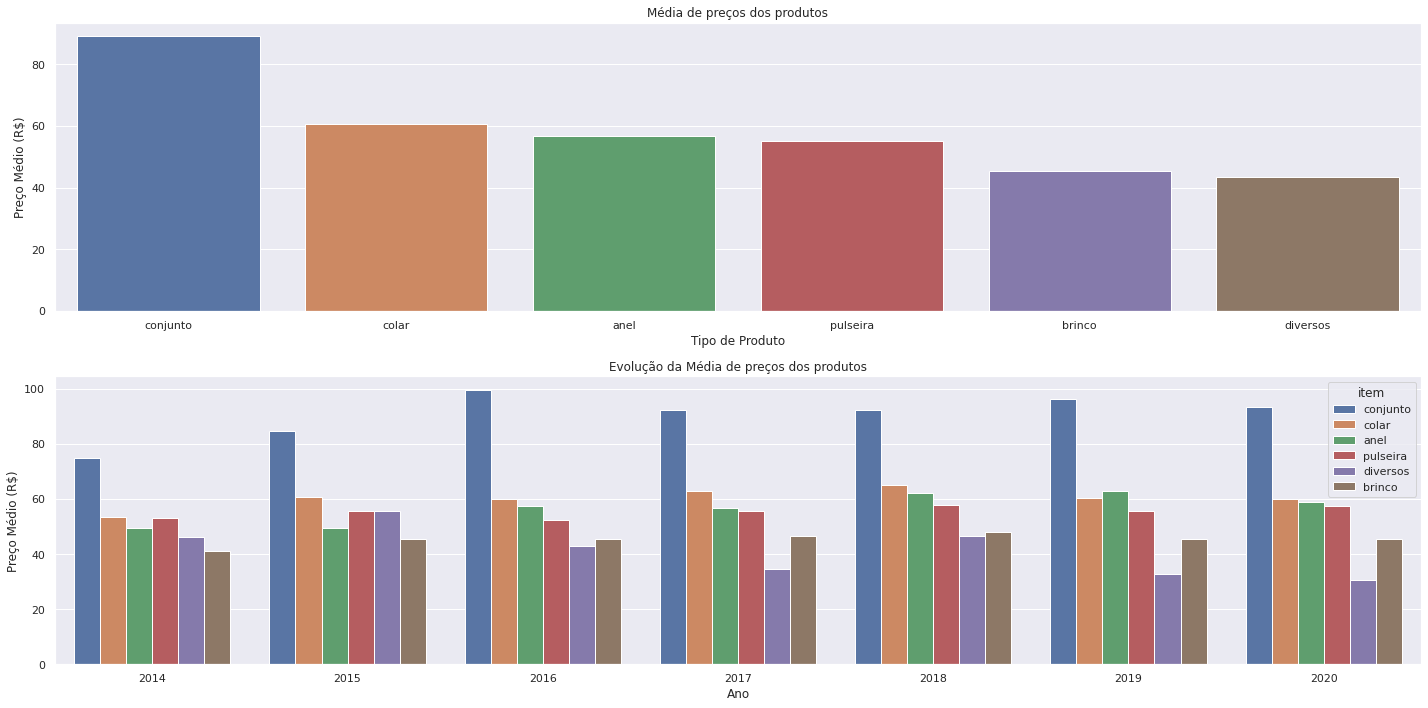

In [ ]:
#@title **Verdadeira.** Conjuntos sempre tiveram a maior média de preços.

aux13_1 = df3[['item', 'valor_base']].groupby('item').mean(
            ).reset_index().sort_values('valor_base',ascending=False)

plt.subplot(2,1,1)
sns.barplot(x = 'item', y='valor_base', data= aux13_1)
plt.title("Média de preços dos produtos")
plt.ylabel("Preço Médio (R$)")
plt.xlabel("Tipo de Produto")

aux13_2 = df3[['ano','item', 'valor_base']].groupby(['ano','item']
            ).mean().reset_index().sort_values('valor_base',ascending=False)

plt.subplot(2,1,2)
sns.barplot(x = 'ano', y='valor_base',hue='item', data= aux13_2)
plt.title("Evolução da Média de preços dos produtos")
plt.ylabel("Preço Médio (R$)")
plt.xlabel("Ano")
plt.tight_layout()



### H14. Jane é a vendedora que mais vende.

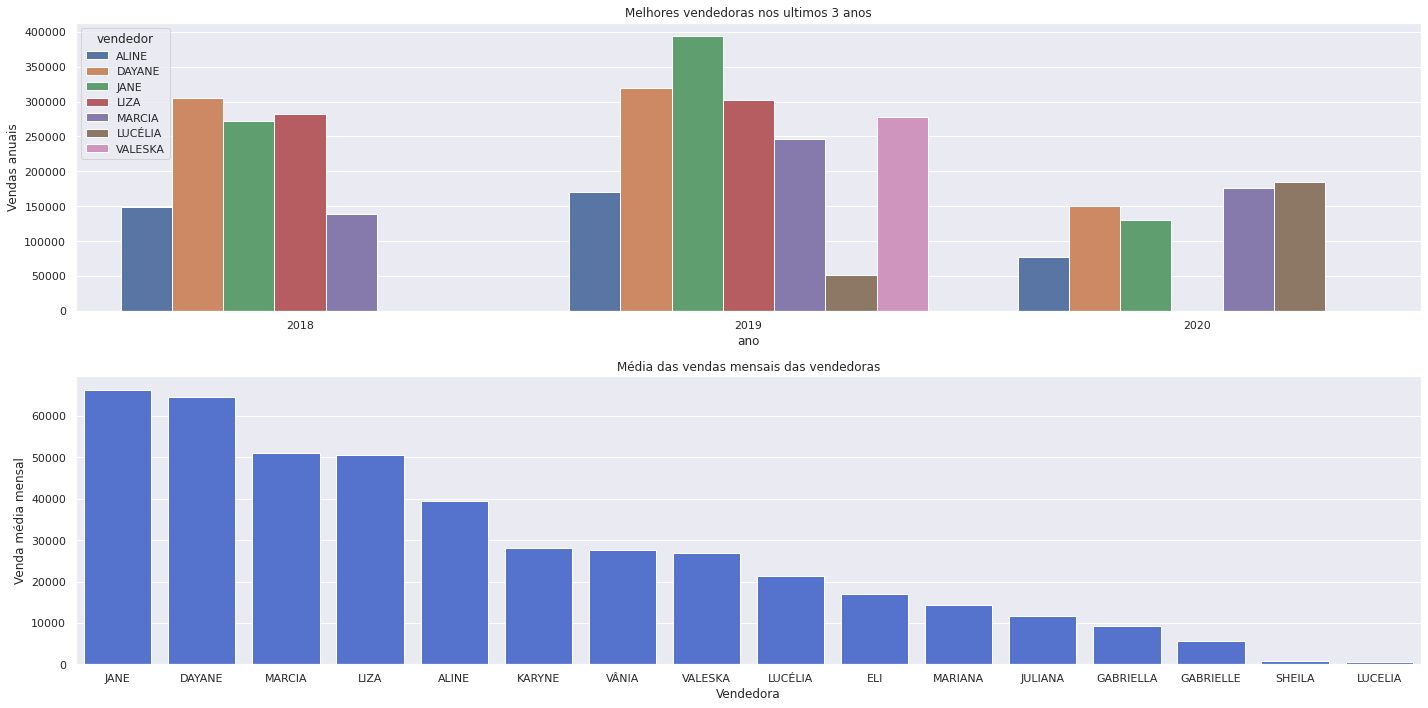

In [ ]:
#@title **Parcialmente Verdadeira.** Jane foi a que mais vendeu em 2019, mas não em 2018 ou 2020. Entretanto, ela possui a maior média de vendas por Mês dos últimos 3 anos.

aux14 = df3[(df3['tipo']=='V') & (df3['vendedor']!='VENDA DIRETA')
            & (df3['ano']>=2018)].copy()
aux14 = aux14[['ano','mes', 'vendedor', 'valor_final']]

aux14_1 = aux14[['ano','vendedor','valor_final']].groupby(
                ['ano', 'vendedor']).sum().reset_index()

aux14_1 = aux14_1[aux14_1['valor_final']>=50000]

plt.subplot(2,1,1)
sns.barplot(x='ano', y='valor_final', hue='vendedor', data=aux14_1)
plt.title("Melhores vendedoras nos ultimos 3 anos")
plt.ylabel("Vendas anuais")
plt.tight_layout()

#Vendas médias por vendedor
aux14_2 = aux14[aux14['ano']>=2018]
aux14_2 = aux14_2[['mes', 'vendedor', 'valor_final']].groupby([
                   'mes','vendedor']).sum().reset_index()
aux14_2 = aux14_2[['vendedor', 'valor_final']].groupby(
                   'vendedor').mean().reset_index().sort_values(
                   'valor_final', ascending = False)

plt.subplot(2,1,2)
sns.barplot(x='vendedor', y= 'valor_final', data = aux14_2, color = 'royalblue')
plt.title("Média das vendas mensais das vendedoras")
plt.ylabel("Venda média mensal")
plt.xlabel("Vendedora")
plt.tight_layout()

### H15. A média de itens por cliente é de 2 peças.

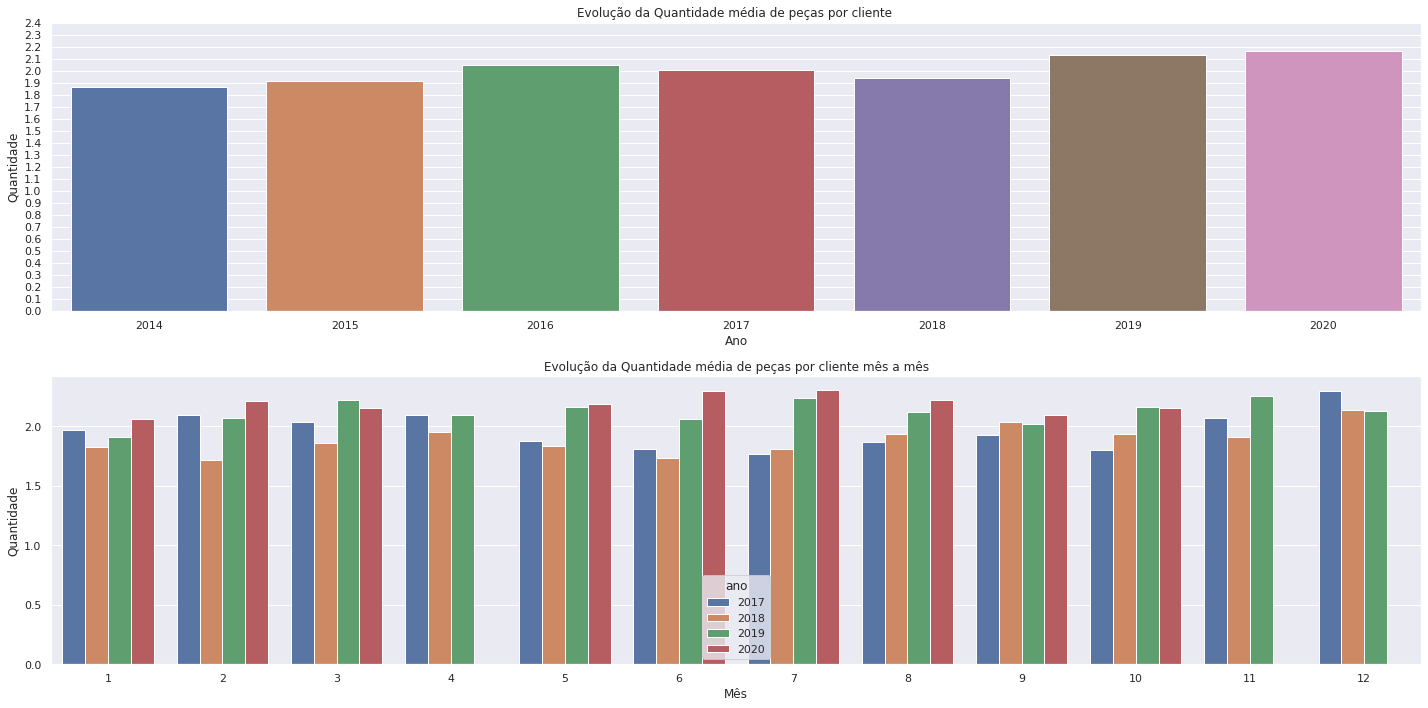

In [61]:
#@title **Verdadeira.** A média de itens por cliente em 2020 foi de 2.2 itens. 
aux15 = df3[df3['tipo']=='V'].copy()

aux15_1 = aux15[['ano','cliente', 'qtde']].groupby(['ano','cliente']
                                                   ).sum().reset_index()

aux15_1 = aux15_1[['ano','qtde']].groupby('ano').mean().reset_index()

plt.subplot(2,1,1)
sns.barplot(x='ano', y='qtde', data=aux15_1)
plt.title("Evolução da Quantidade média de peças por cliente ")
plt.ylabel("Quantidade")
plt.xlabel("Ano")
plt.yticks(np.arange(0,2.5,0.1))

aux15_2 = aux15[aux15['ano']>=2017]
aux15_2 = aux15_2[['ano', 'mes', 'cliente', 'qtde']].groupby(
                  ['ano', 'mes', 'cliente']).sum().reset_index()
aux15_2 = aux15_2[['ano','mes','qtde']].groupby(['ano','mes']).mean(
                                                ).reset_index()

plt.subplot(2,1,2)
sns.barplot(hue='ano', y='qtde', x='mes', data=aux15_2)
plt.title("Evolução da Quantidade média de peças por cliente mês a mês")
plt.ylabel("Quantidade")
plt.xlabel("Mês")

plt.tight_layout()


### H16. Ao menos 20% das vendas estão acima do Ticket Médio em dezembro.

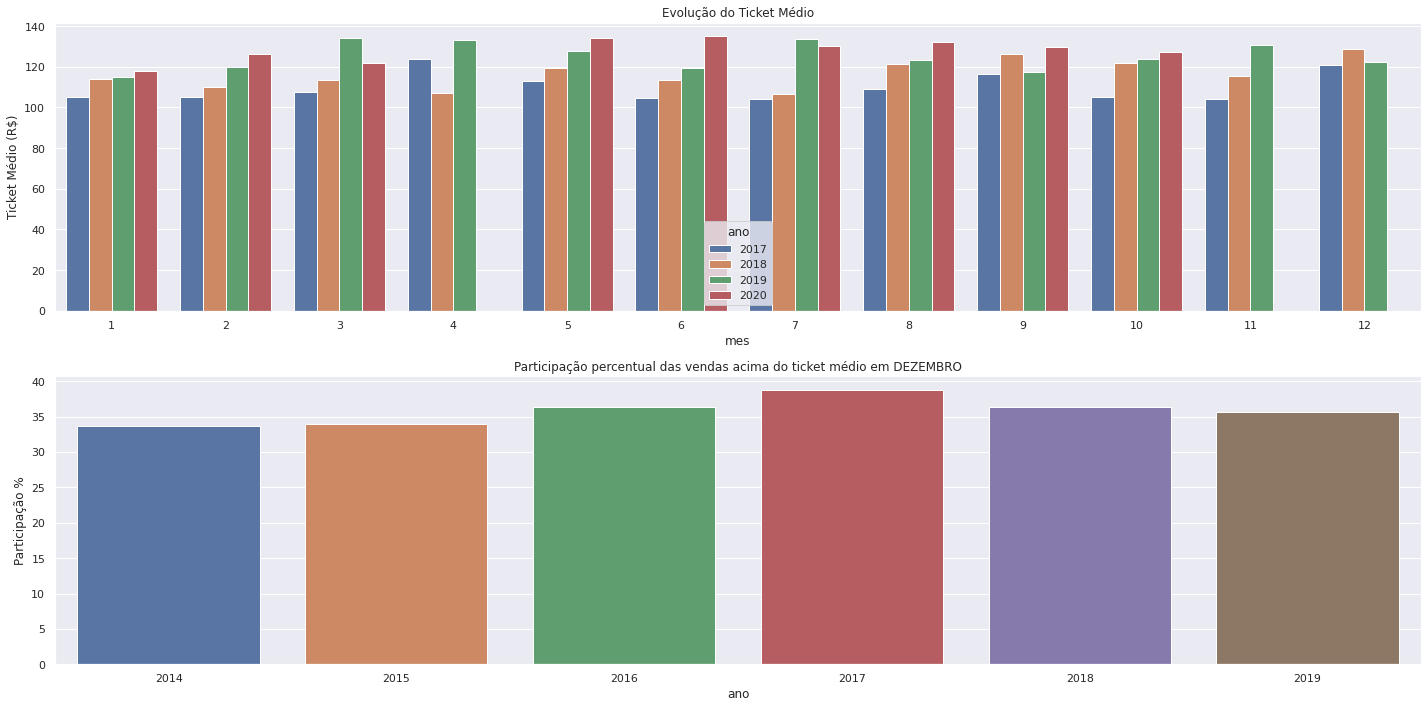

In [67]:
#@title **Verdadeiro.** Geralmente cerca de 35% das vendas ficam acima do ticket médio em dezembro.

#Calcular ticket médio:
aux16 = df3[df3['tipo']=='V']
aux16 = aux16[['cliente', 'ano','mes','valor_final']].groupby(
              ['ano','mes','cliente']).sum().reset_index()

aux16_1 = aux16[['ano', 'mes','valor_final']].groupby(['ano','mes']
                                              ).mean().reset_index()
aux16_1 = aux16_1[aux16_1['ano']>=2017]
aux16_1.columns = ['ano','mes','ticket_medio']

plt.subplot(2,1,1)
sns.barplot(x='mes', y='ticket_medio', hue='ano', data=aux16_1)
plt.ylabel("Ticket Médio (R$)")
plt.title("Evolução do Ticket Médio")
plt.tight_layout()

#Segundo gráfico
aux16_2 = aux16[['ano', 'mes','valor_final']].groupby(['ano','mes']
                                              ).mean().reset_index()
aux16_2 = aux16_2[aux16_2['mes']==12]
aux16_2.columns = ['ano','mes','ticket_medio']

aux16_3 = aux16[['cliente', 'ano','mes','valor_final']].groupby(
              ['ano','mes','cliente']).sum().reset_index()
aux16_3 = aux16_3[aux16_3['mes']==12]

#Criando um dicionário
ticket_dic = dict(zip(aux16_2['ano'],aux16_2['ticket_medio']))
aux16_3['ticket_medio'] = aux16_3['ano'].map(ticket_dic)
aux16_3['flag'] = aux16_3[['valor_final','ticket_medio']].apply(
                          lambda x: 1 if x['valor_final']>x['ticket_medio']
                          else 0, axis=1)

aux16_3 = aux16_3[['ano','mes','flag','valor_final']].groupby(
                  ['ano','mes','flag']).count().reset_index()
 
for x in range(len(aux16_3)):
  if aux16_3.loc[x,'flag']==1:
    aux16_3.loc[x,'participação'] = 100*np.round(
        aux16_3.loc[x,'valor_final']/(
        aux16_3.loc[x,'valor_final']+aux16_3.loc[x-1,'valor_final'])
        ,decimals=4)
  else:
        aux16_3.loc[x,'participação'] = 0
        
aux16_3 = aux16_3[aux16_3['flag']==1]
plt.subplot(2,1,2)
sns.barplot(x='ano',y='participação', data=aux16_3)
plt.title("Participação percentual das vendas acima do ticket médio em DEZEMBRO")
plt.ylabel("Participação %")
plt.tight_layout()



### H17. Ao menos 5% do faturamento é proveniente de vendas com valor acima de R$500,00

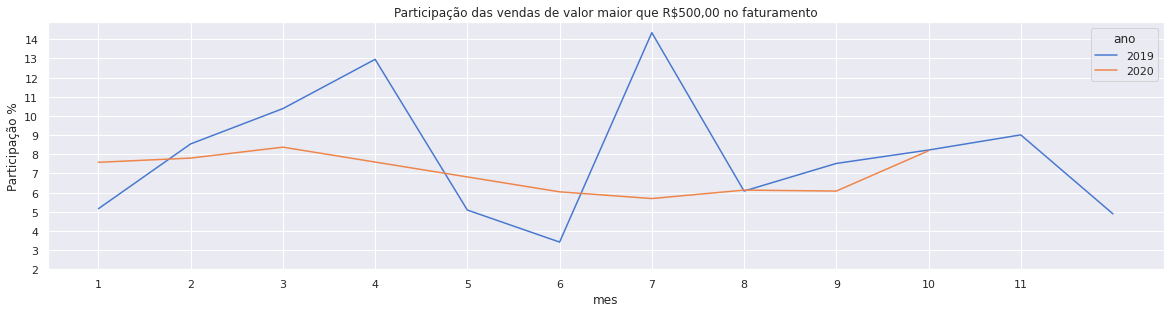

In [246]:
#@title **Verdadeira.** Em 2019 e 2020, na maior parte do tempo, as vendas acima de R$500,00 corresponderam a mais de 5% do faturamento.

aux17 = df3[df3['tipo']=='V']
aux17 = aux17[['ano','mes','cliente', 'valor_final']].groupby(
              ['ano','mes','cliente']).sum().reset_index()


aux17_1 = aux17.copy()
aux17_1['flag']=aux17_1['valor_final'].apply(lambda x: 1 if x>500 else 0)
aux17_1 = aux17_1[['ano','mes','flag','valor_final']].groupby(
                  ['ano','mes','flag']).sum().reset_index()

for x in range(len(aux17_1)):
  if aux17_1.loc[x,'flag']==1:
    aux17_1.loc[x,'participação'] = 100*np.round(
        aux17_1.loc[x,'valor_final']/(
        aux17_1.loc[x,'valor_final']+aux17_1.loc[x-1,'valor_final'])
        ,decimals=4)
  else:
        aux17_1.loc[x,'participação'] = 0
aux17_1 = aux17_1[(aux17_1['flag']==1) & (aux17_1['ano']>2018)]
plt.subplot(2,1,1)
sns.lineplot(hue='ano', y='participação',x='mes',data=aux17_1,
             palette = 'muted')
plt.yticks(np.arange(2,15,1));
plt.xticks(np.arange(1,12,1));
plt.ylabel("Participação %")
plt.title("Participação das vendas de valor maior que R$500,00 no faturamento");


### H18. O faturamento caiu após a pandemia.

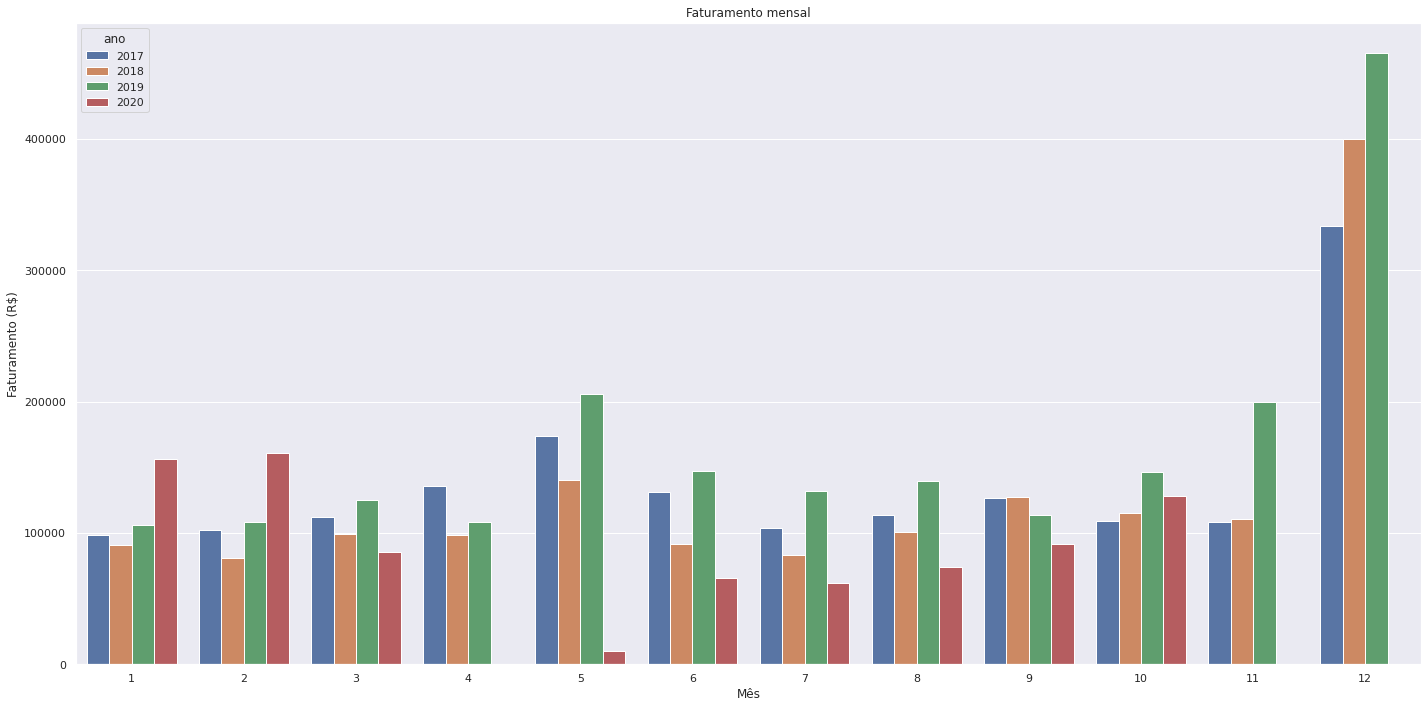

In [72]:
#@title **Verdadeira.** Houve uma queda em março, com a loja ficando fechada em abril. A loja mostra sinais de recuperação, tendo superado em outubro o faturamento de 2018 para esse mesmo mês.

aux18 = df3[(df3['tipo']=='V') & (df3['ano']>=2017)].copy()
aux18 = aux18[['ano','mes','valor_final']].groupby(['ano','mes']
                                                   ).sum().reset_index()
                      
sns.barplot(hue='ano', y='valor_final', x='mes', data=aux18 )
plt.title("Faturamento mensal")
plt.ylabel('Faturamento (R$)')
plt.xlabel("Mês")
plt.tight_layout()


### H19. O número de clientes caiu após a pandemia

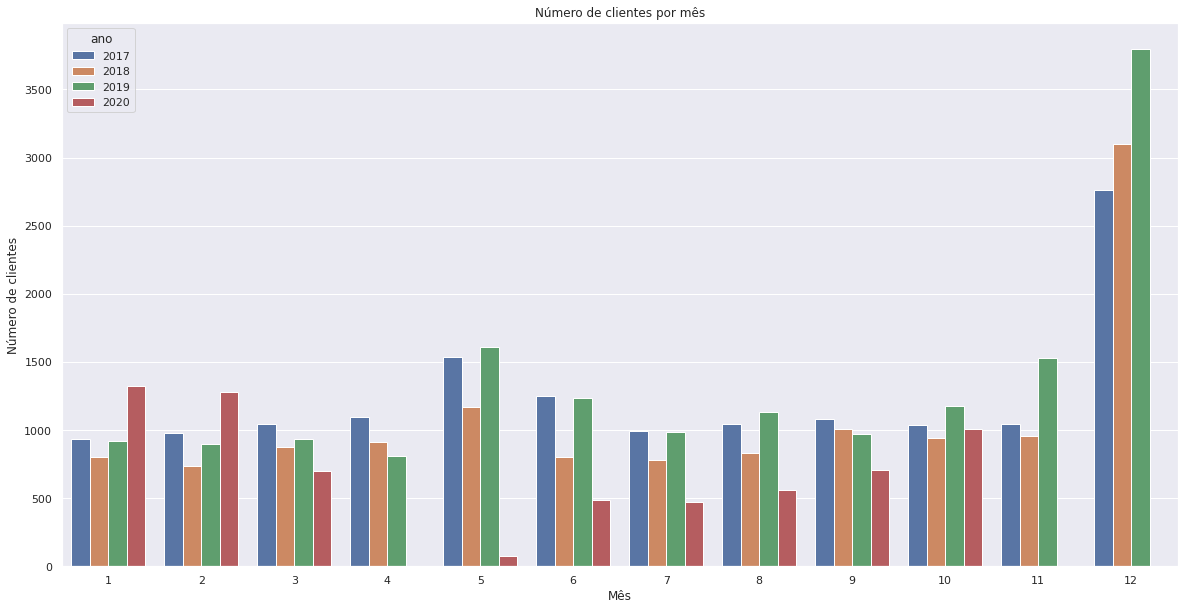

In [55]:
#@title Verdadeira. Houve uma queda brusca no número de clientes em Maio, Junho e Julho, mas setembro e outubro mostram sinais de recuperação.
aux19 = df3[(df3['tipo']=='V') & (df3['ano']>=2017)].copy() 
aux19 = aux19[['ano', 'mes', 'cliente','qtde']].groupby(
               ['ano','mes','cliente']).count().reset_index()
               
aux19 = aux19[['ano', 'mes', 'cliente']].groupby(
               ['ano','mes']).count().reset_index()

#Plotando:
sns.barplot(x='mes',hue='ano',y='cliente',data=aux19)
plt.title("Número de clientes por mês")
plt.ylabel("Número de clientes")
plt.xlabel("Mês");

### Conclusão

In [103]:
auxc = aux15_2[aux15_2['ano']>=2019].reset_index()
auxc_2 = aux16_1[aux16_1['ano']>=2019].copy().reset_index()
auxc_3 = aux18[aux18['ano']>=2019].reset_index()
auxc_4 = aux19[aux19['ano']>=2019].reset_index()

In [112]:
conc = auxc[['ano','mes','qtde']].copy()
conc['ticket_medio']= auxc_2['ticket_medio'].copy()
conc['faturamento'] = auxc_3['valor_final'].copy()
conc['n_clientes'] = auxc_4['cliente'].copy()

In [116]:
conc.columns = ['Ano', 'Mês', 'Itens_cliente', 'Ticket_Médio', 'Faturamento_mensal', 'Número_clientes']
cols = ['Ano', 'Mês','Número_clientes', 'Itens_cliente', 'Ticket_Médio', 'Faturamento_mensal']
conc = conc[cols]

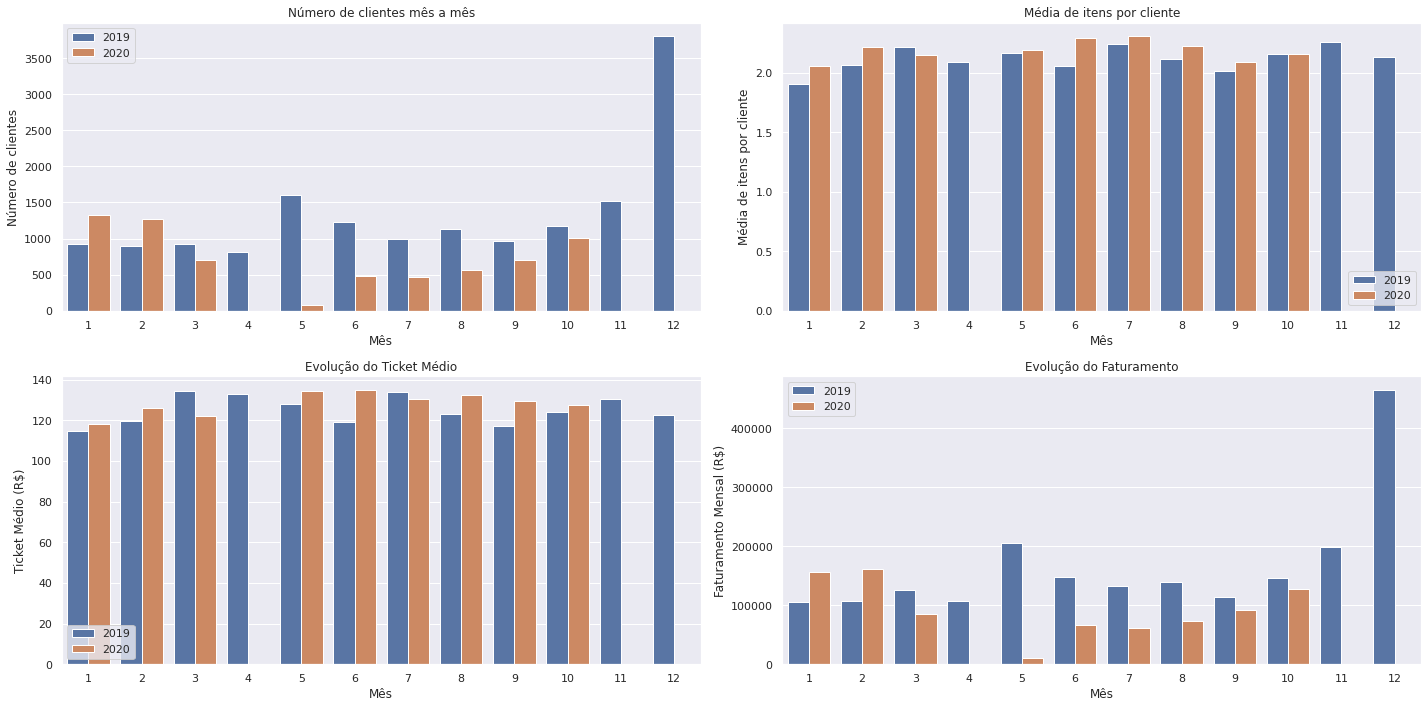

In [133]:
plt.subplot(2,2,1)
sns.barplot(x='Mês', y ='Número_clientes', hue='Ano', data = conc )
plt.title("Número de clientes mês a mês")
plt.ylabel("Número de clientes")
plt.legend(loc='upper left')
plt.tight_layout()

plt.subplot(2,2,2)
sns.barplot(x='Mês', y ='Itens_cliente', hue='Ano', data = conc )
plt.title("Média de itens por cliente")
plt.ylabel("Média de itens por cliente")
plt.legend(loc = 'lower right')
plt.tight_layout()

plt.subplot(2,2,3)
sns.barplot(x='Mês', y ='Ticket_Médio', hue='Ano', data = conc )
plt.title("Evolução do Ticket Médio")
plt.ylabel("Ticket Médio (R$)")
plt.legend(loc = 'lower left')
plt.tight_layout()

plt.subplot(2,2,4)
sns.barplot(x='Mês', y ='Faturamento_mensal', hue='Ano', data = conc )
plt.title("Evolução do Faturamento")
plt.ylabel("Faturamento Mensal (R$)")
plt.legend(loc = 'upper left')
plt.tight_layout()